# Определение возраста покупателей

# Описание проекта
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

# Цель проекта
Построить модель, которая по фотографии определит приблизительный возраст человека. 

## Исследовательский анализ данных

Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Сохраним датафрейм в переменную `labels`

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


- Оценим размер выборки

In [3]:
labels.shape

(7591, 2)

- Пропуски в данных

In [4]:
labels.isna().sum()

file_name    0
real_age     0
dtype: int64

- Данные в колонке возраста

In [5]:
labels['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

Построим гистограмму распределения возраста нашей выборки 

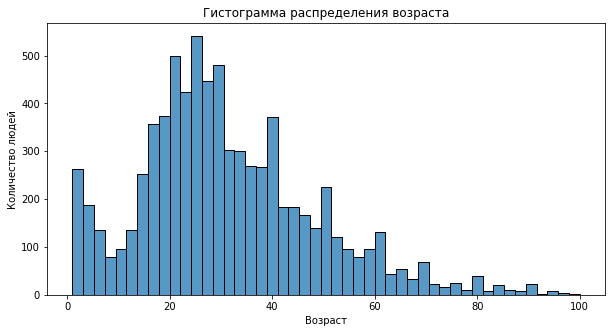

In [6]:
plt.figure(figsize=(10, 5))

sns.histplot(labels['real_age'])

plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('Гистограмма распределения возраста')

plt.show();

Получим изображения с помощью  `ImageDataGenerator`

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Посмотрим на 15 изображений из выборки

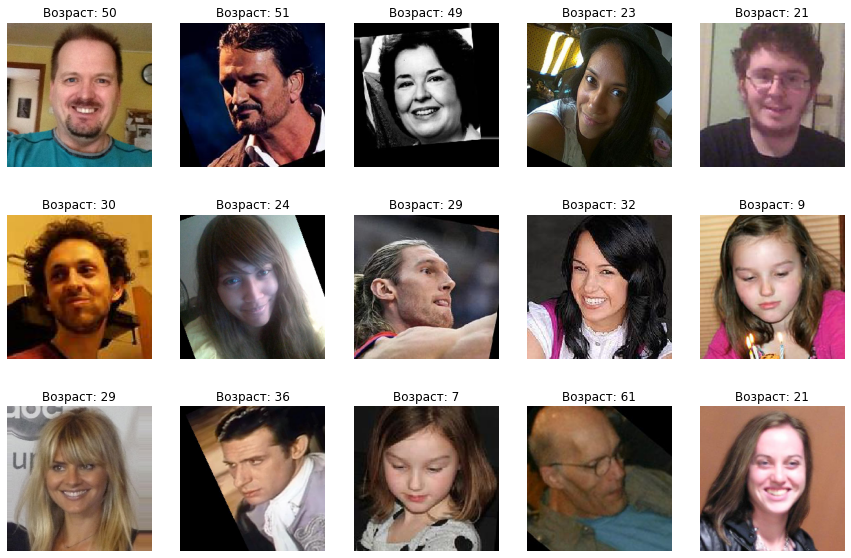

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 10))

for i in range(15):
    img, label = train_gen_flow.next()
    ax[i//5, i%5].imshow(img[0])
    ax[i//5, i%5].set_title(f"Возраст: {label[0]}")
    ax[i//5, i%5].axis('off')
    
plt.show()

# Вывод:

В результате проведенного анализа данных можно подчеркнуть следующие моменты:
- выборка содержит `7591` изображение
- в данных отсутствуют пропуски
- минимальный возраст равен `1` году, максимальный `100` лет
- отсутствуют аномальные значения
- большая часть распределения возраста в районе `30` лет
- при просмотре части фотографий заметили, что `аугментация` уже была проведена 

Размер изображений будем использовать 224х224 (значение по умолчанию для ResNet50)

Приступим к обучению модели

## Обучение модели

Обучение модели проводилось на сервере.
Подготовлены функции для загрузки в тренажер Яндекса.

```python
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


def load_train(path):
    

    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset = 'training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    
    labels = pd.read_csv(path + 'labels.csv')
    
    validation_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    
    test_gen_flow = validation_datagen.flow_from_dataframe(
    dataframe = labels,
    directory=path +'final_files/',
    x_col="file_name",
    y_col="real_age", 
    class_mode="raw", 
    target_size=(224,224), 
    batch_size=32,
    subset = "validation",
    seed=12345,
    )

    return test_gen_flow


def create_model(input_shape, optimizer = Adam(lr=0.0003)):
    
    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    
    model = Sequential()
    
    model.add(backbone)
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=12,
                steps_per_epoch=None, validation_steps=None):


    model.fit(train_data, validation_data=test_data, batch_size=batch_size, 
              epochs=epochs, steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, verbose=2)

    return model

```

Метрика **MAE** на всех 12 эпохах для обучающей и валидационной выборках:

```

Train for 178 steps, validate for 60 steps
Epoch 1/12
178/178 - 52s - loss: 199.9899 - mae: 10.3673 - val_loss: 975.7377 - val_mae: 26.4976
Epoch 2/12
178/178 - 42s - loss: 79.2574 - mae: 6.6943 - val_loss: 619.8604 - val_mae: 19.6162
Epoch 3/12
178/178 - 43s - loss: 42.7884 - mae: 5.0109 - val_loss: 364.1886 - val_mae: 14.0813
Epoch 4/12
178/178 - 42s - loss: 28.8735 - mae: 4.1557 - val_loss: 133.6728 - val_mae: 8.6764
Epoch 5/12
178/178 - 43s - loss: 21.4942 - mae: 3.5609 - val_loss: 94.7618 - val_mae: 7.5351
Epoch 6/12
178/178 - 42s - loss: 15.1773 - mae: 3.0126 - val_loss: 82.9610 - val_mae: 6.8466
Epoch 7/12
178/178 - 41s - loss: 11.5862 - mae: 2.6263 - val_loss: 73.4055 - val_mae: 6.6028
Epoch 8/12
178/178 - 40s - loss: 9.3873 - mae: 2.3333 - val_loss: 68.4015 - val_mae: 6.3450
Epoch 9/12
178/178 - 42s - loss: 8.7545 - mae: 2.2668 - val_loss: 78.6807 - val_mae: 6.9658
Epoch 10/12
178/178 - 44s - loss: 9.2545 - mae: 2.3119 - val_loss: 77.3727 - val_mae: 6.7993
Epoch 11/12
178/178 - 43s - loss: 9.8616 - mae: 2.3987 - val_loss: 67.7741 - val_mae: 6.2817
Epoch 12/12
178/178 - 43s - loss: 8.7055 - mae: 2.2271 - val_loss: 65.8763 - val_mae: 6.0887

60/60 - 10s - loss: 65.8763 - mae: 6.0887
Test MAE: 6.0887

```

## Анализ обученной модели

В качестве основного слоя для модели использовали:
- **`ResNet50`** предобученный на датасете **`ImageNet`**
- далее использовался **`Dropout(0.2)`** для предотвращения переобучения модели (с вероятностью 20% отключала некоторые нейроны)
- следующий слой **`GlobalAveragePooling2D()`** выполняет операцию усреднения по всем пикселям на каждом канале карты признаков, что приводит к тому, что получается один вектор признаков для всего изображения
- и в конце **`Dense()`**- полносвязный слой, принимающий на вход вектор признаков и преобразующий его в выходное значение  используя функцию активации "relu"

При компиляции модели использовались следующие параметры:
- **`optimizer`** - **`Adam`** с **`learning rate`** равным **`0.0003`**
- **`функция потерь (loss) - MSE`**
- **`метрика качества (metrics) - MAE`**

# Вывод:

Метрика **`MAE`** на **`обучающей выборке`** показала результат - **`2.2271`**

Метрика **`MAE`** на **`тесте`** показала результат - **`6.0887`**

Наблюдается переобучение модели, но конечный результат укладывается в условие **`MAE < 8`**